In [1]:
import os
import shutil
import pandas as pd
import holidays
from time import time
from datetime import date, datetime, timezone
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Aggregated demand data

In [31]:
def to_datetime(df, col_name):
    try:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d.%m.%Y', utc=True))
    except:
        df.index = df[col_name].apply(lambda x: pd.to_datetime(str(x), format='%d/%m/%Y', utc=True))    
    df.index = df.index.date
    df.index = pd.to_datetime(df.index) 
    return df.index

## Trading Hub Europe: SLPs & RLMs

THE original data

In [32]:
#read
the = pd.read_csv(os.path.join(data_path, "THE.csv"), sep=";")
the.index = to_datetime(the, "Gastag")


the_new = pd.read_csv(os.path.join(data_path, "THE_new.csv"), sep=";")
the_new.index = to_datetime(the_new, "Gasday")
#the_new.index = the_new["Gasday"]
#the_new.index = to_datetime(the_new, the_new.index)

the = pd.concat([the, the_new], axis=0)

#to numeric
the = the[the.columns[~the.columns.isin(["Gastag", "Status", "Gasday", "State"])]].fillna("0")
the = the.iloc[::-1] 
the = the.apply(lambda x: x.apply(lambda y: float(y.replace(".", "").replace(",", ""))))

#from kWh to TWh
the = the / (10**9)

Gas pool data from: https://www.tradinghub.eu/de-de/Download/Archiv-GASPOOL / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [33]:
gaspool = pd.read_csv(os.path.join(data_path, "gaspool.csv"), sep=";")
gaspool.index = to_datetime(gaspool, "Datum")
gaspool.drop("Datum", axis=1, inplace=True)

#from MWh to TWh
gaspool = gaspool / (10**6)

NCG data from:https://www.tradinghub.eu/de-de/Download/Archiv-NetConnect-Germany / "Sonstiges" / "Aggregierte Verbrauchsdaten"

In [34]:
#in KWh
ncg = pd.read_csv(os.path.join(data_path, "ncg.csv"), sep=";")
ncg.index = to_datetime(ncg, "DayOfUse")

ncg.drop(["DayOfUse", "Status"], axis=1, inplace=True)
ncg.drop(list(ncg.filter(like='Unit', axis=1).columns), axis=1, inplace=True)

#from kWh to TWh
ncg = ncg / (10**9)

In [35]:
def get_df_name(df):
    return [x for x in globals() if globals()[x] is df][0]

def return_summed_df(df, domain, name):
    return df[df.filter(like=domain, axis=1).columns].sum(1).to_frame().rename(
    columns={0:"{}_{} [TWh]".format(domain, name)})

def sum_consumptions(df):    
    name = get_df_name(df)
    return return_summed_df(df, "SLP", name), return_summed_df(df, "RLM", name) 

def sum_single_col_dfs(df_1, df_2, slp_sum=True, **alternative_name):
    if slp_sum==False:
        name = alternative_name.values()
        return (df_1.iloc[:,0] + df_2.iloc[:,0]).to_frame().rename(columns={
            0:name}) 
    else: 
        name = get_df_name(df_1).split("_")[0]
        return (df_1.iloc[:,0] + df_2.iloc[:,0]).to_frame().rename(columns={
            0:"{}_sum [TWh]".format(name)})

In [36]:
the_slp, the_rlm = sum_consumptions(the)
gaspool_slp, gaspool_rlm = sum_consumptions(gaspool)
ncg_slp, ncg_rlm = sum_consumptions(ncg)

the_sum = sum_single_col_dfs(the_slp, the_rlm)
gaspool_sum = sum_single_col_dfs(gaspool_slp, gaspool_rlm)
ncg_sum = sum_single_col_dfs(ncg_slp, ncg_rlm)

before_the_slp = sum_single_col_dfs(gaspool_slp, ncg_slp).loc[gaspool_slp.index]
before_the_rlm = sum_single_col_dfs(gaspool_rlm, ncg_rlm).loc[gaspool_slp.index]
before_the_sum = sum_single_col_dfs(ncg_sum, gaspool_sum, slp_sum=False, 
                                    alternative_name="aggregated_gaspool_ngc").loc[gaspool_slp.index]

the_whole_slp = pd.concat([the_slp, before_the_slp], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_slp"})
the_whole_rlm = pd.concat([the_rlm.iloc[:,0], before_the_rlm], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_rlm"})
the_whole_sum = pd.concat([the_sum, before_the_sum], axis = 0).sum(1).sort_index(
    ).to_frame().rename(columns={0:"the_combined_sum"})

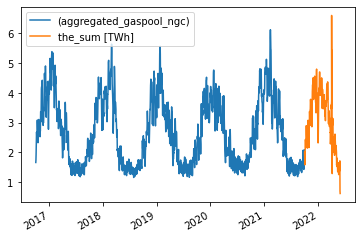

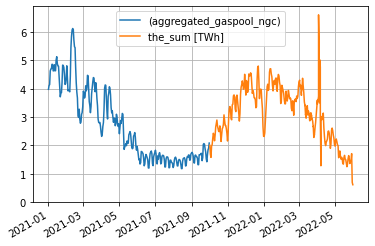

In [37]:
series_all = pd.concat([before_the_sum, the_sum], axis=0)
series_all.plot()
series_all["2021-01-01":].plot(ylim=0)
plt.grid()

In [10]:
the_whole_slp[the_whole_slp.index.year==2020].sum()

the_combined_slp    379.140945
dtype: float64

# Proxies / control variables / disaggregated demand
## Estimated SLP

In [45]:
estimated = pd.read_csv(os.path.join(data_path, "SLPs_new.csv"), index_col=0)
estimated.index = pd.to_datetime(
    pd.to_datetime(estimated.index).date
)

<AxesSubplot:>

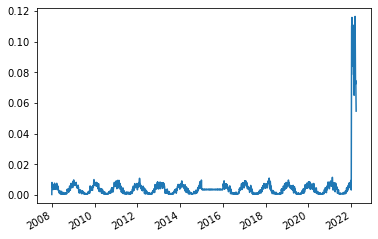

In [47]:
#hier wird falsch eingelesen

estimated['dist_heat'].plot()

In [48]:
estimated["commercial"] = estimated[["commercial_space TWh", "commercial_water TWh"]].sum(1)
estimated["residential"] = estimated[["residential_space TWh", "residential_water TWh"]].sum(1)

In [49]:
#estimated["scaled_district_heat"][estimated.index.year>=2020].plot()

Gas consumption according to AGEB in decentralized units will be mostly small CHP and hence temperature dependent. THis increases overall temperature-dependent gas consumption from 384 to 396 TWh.

In [50]:
estimated["scaled_space_private"] = estimated['residential'] * 254 / estimated['residential'][
    estimated.index.year==2020].sum()

estimated["scaled_space_tertiary"] = estimated['commercial'] * 98 / estimated['commercial'][
    estimated.index.year==2020].sum()

estimated["scaled_decentral_chp"] = estimated['commercial'] * 15 / estimated['commercial'][
    estimated.index.year==2020].sum()

estimated["scaled_space_industry"] = estimated['commercial'] * 25 / estimated['commercial'][
    estimated.index.year==2020].sum()

#estimated["scaled_district_heat"] = estimated['dist_heat'] * 19 / estimated['dist_heat'][
#    estimated.index.year==2020].sum()

estimated['aggregated(incl_small_chp)'] = estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry"]
                                                   ].sum(1)


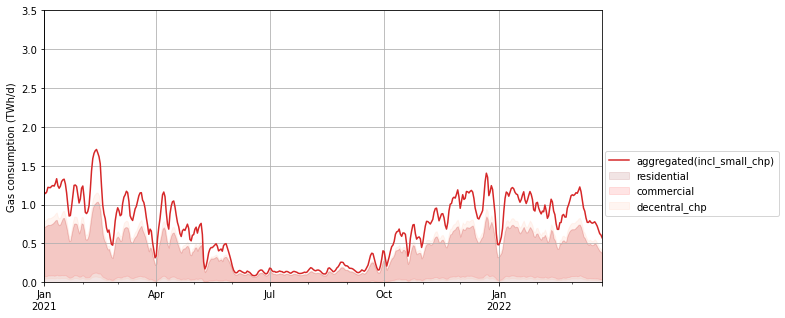

In [51]:
estimated.loc[estimated.index.year>=2021,'aggregated(incl_small_chp)'].plot(color='tab:red', figsize=(10,5))
plt.grid()

estimated2020 = estimated[estimated.index.year==2020]['aggregated(incl_small_chp)']
estimated2021 = estimated.loc["2021-01-01":]

plt.fill_between(estimated2020.index, 0, estimated2020, color='tab:red', alpha=0.1)

bottom = 0
for sector, c, label in [("scaled_space_private", "maroon", "residential"), (
    "scaled_space_industry","red", "commercial"), ("scaled_decentral_chp", "lightsalmon", "decentral_chp") ]:
    plt.fill_between(estimated2021.index, bottom, estimated2021[sector], color=c, alpha=0.1, label = label)
    bottom += estimated2021[sector]

plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.legend(loc='upper right', bbox_to_anchor=(1.325, 0.5))
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas for electricity generation

In [76]:
electricity_from_gas = pd.read_csv(os.path.join(data_path, "electricity_from_gas.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]

electricity_from_gas.index = pd.to_datetime(
    pd.to_datetime(electricity_from_gas.index).date
)
electricity_from_gas = electricity_from_gas /10**6

# earlier data

el_update = pd.read_csv(os.path.join(data_path, "entsoe_new.csv"), 
                                   index_col=0, parse_dates=True).iloc[:, 0]
el_update.index = pd.to_datetime(
    el_update.index.map(lambda x: x.date())
)

# concat

electricity_from_gas = pd.concat([el_update, electricity_from_gas], axis=0)

In [78]:
energy_agbl = {
    "2016": 80.6,
    "2017": 86,
    "2018": 81.6,
    "2019": 90,
    "2020": 94.7,
    "2021": 89.7,
}

In [79]:
for key in list(energy_agbl.keys()):
    electricity_from_gas[electricity_from_gas.index.year==int(key)] = electricity_from_gas[electricity_from_gas.index.year==int(key)] * energy_agbl[key] / electricity_from_gas[electricity_from_gas.index.year==int(key)].sum() 

Scaled to 185 TWh in 2020, which is the sum of public power plants, public CHP, and industrial power plants (probably also mostly CHP):

In [80]:
gas_to_electricity = electricity_from_gas * 189 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

gas_to_electricity_public_pp = electricity_from_gas * 106 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

gas_to_electricity_public_chp = electricity_from_gas * 34 / (
    electricity_from_gas[electricity_from_gas.index.year==2020].sum())

electricity_from_gas.name = "electricity_from_gas"    
gas_to_electricity.name = "gas_to_electricity"  

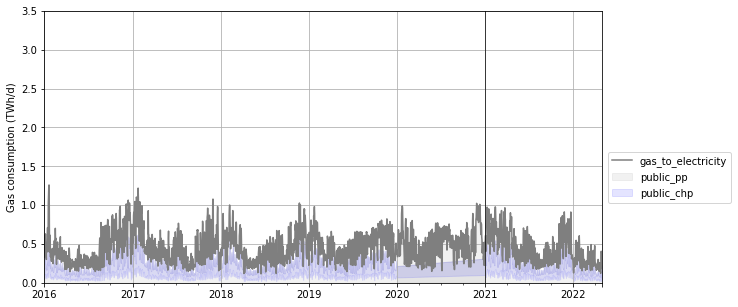

In [81]:
gas_to_electricity.plot(color='tab:grey', figsize=(10,5))
plt.grid()
power2020 = gas_to_electricity[gas_to_electricity.index.year==2020]
index_21_22 = gas_to_electricity[gas_to_electricity.index.year!=2020].index

plt.fill_between(power2020.index, 0, power2020, color='tab:grey', alpha=0.1)
plt.fill_between(index_21_22, 0, gas_to_electricity_public_pp[index_21_22], color='grey', alpha=0.1, label="public_pp")
plt.fill_between(index_21_22, gas_to_electricity_public_pp[index_21_22], gas_to_electricity_public_chp[index_21_22], color='blue', alpha=0.1, label="public_chp")


plt.legend(loc='upper right', bbox_to_anchor=(1.24, 0.5))
plt.xlabel('')
plt.ylabel('Gas consumption (TWh/d)')
plt.ylim(0, 3.5)
plt.axvline('2021-01-01', color='black', linewidth=0.7)
#plt.axvline('2022-01-01', color='black', linewidth=0.7)

## Gas prices

In [82]:
gas_prices = pd.read_csv(os.path.join(data_path, "Dutch TTF Natural Gas Futures Recent.csv"), index_col=0)
gas_prices = gas_prices["Price"].to_frame().rename(columns={
    "Price":"gas_price [€/MWh]"}).dropna()
gas_prices.index = pd.to_datetime(gas_prices.index, utc = True).date

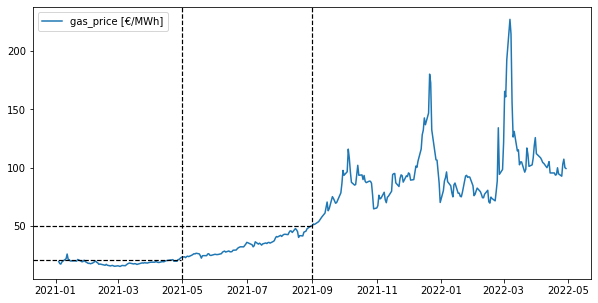

In [83]:
gas_prices.plot(figsize=(10,5))
plt.axvline(x="2021-09-1", color='k', linestyle='--', lw=1.2)
plt.axvline(x="2021-05-1", color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.5, y=50, color='k', linestyle='--', lw=1.2)
plt.axhline(xmax=0.265, y=21, color='k', linestyle='--', lw=1.2)

Combine sources

In [84]:
the_whole_slp = the_whole_slp.drop_duplicates()
the_whole_rlm = the_whole_rlm.drop_duplicates()
gas_prices = gas_prices.drop_duplicates()

In [85]:
df_all = the_whole_slp.join(
    [the_whole_rlm, gas_to_electricity, electricity_from_gas, 
        gas_prices, estimated[
    ["scaled_space_private","scaled_space_tertiary","scaled_decentral_chp","scaled_space_industry", 'aggregated(incl_small_chp)']
                                                   ]
    ]
)

In [87]:
df_all.head()

,the_combined_slp,the_combined_rlm,gas_to_electricity,electricity_from_gas,gas_price [€/MWh],scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,aggregated(incl_small_chp)
2016-10-01,0.396332,1.262703,0.567599,0.284400,NaN,0.168296,0.035030,0.005362,0.008936,0.217624
2016-10-02,0.511865,1.229047,0.526653,0.263884,NaN,0.208305,0.051859,0.007938,0.013229,0.281330
2016-10-03,0.616591,1.300171,0.546110,0.273633,NaN,0.247985,0.076650,0.011732,0.019554,0.355921
2016-10-04,0.709381,1.546009,0.425086,0.212993,NaN,0.275558,0.090982,0.013926,0.023210,0.403675
2016-10-05,0.882730,1.629043,0.476079,0.238543,NaN,0.335879,0.122167,0.018699,0.031165,0.507910


In [88]:
first = the_whole_slp.iloc[0].name
last = the_whole_slp.iloc[-1].name

def unify_index(df):
    try:
        return df.loc[(df.index >= first) & (df.index <= last)]
    except:
        return df.loc[(df.index.date >= first) & (df.index.date <= last)]

In [89]:
df_all = unify_index(df_all)

In [90]:
df_all.tail

<bound method NDFrame.tail of             the_combined_slp  the_combined_rlm  gas_to_electricity  \
2016-10-01          0.396332          1.262703            0.567599   
2016-10-02          0.511865          1.229047            0.526653   
2016-10-03          0.616591          1.300171            0.546110   
2016-10-04          0.709381          1.546009            0.425086   
2016-10-05          0.882730          1.629043            0.476079   
...                      ...               ...                 ...   
2022-05-27          0.435938          1.022803                 NaN   
2022-05-28          0.528253          0.939121                 NaN   
2022-05-29          0.646633          1.066055                 NaN   
2022-05-30          0.697862               NaN                 NaN   
2022-05-31          0.615783               NaN                 NaN   

            electricity_from_gas  gas_price [€/MWh]  scaled_space_private  \
2016-10-01              0.284400                NaN 

# Analysis & plotting

## Align indexes
All calculations and plots are done for the same period: 01.10.2021-25.03.2022

# Subtract gas for electricity generation

## THE vs. our estimates

In [ ]:
y1=df_all["aggregated(incl_small_chp)"]
y2= df_all["the_combined_slp"]
y3 = df_all["the_combined_rlm"]

### Weekly analyis: Russian invasion: 24.02. (Thu), Fasching: 28.02.-02.03. (Mon-Wed)

In [ ]:
ax = (y3 - 0.34*y1).to_frame().rename(columns={0:"RLM minus SLP "}).plot()
ax.set_ylim(0,2.5)
y3.plot(
    ax=ax, title = "RLM; RLM minus temperature-dependant SLP", figsize=(10,5))
plt.show()

In [ ]:
ax = y2.plot()
y1.plot(ax=ax, figsize=(10,5))

plt.show()

# Export

In [91]:
df = df_all

In [92]:
df['index']= df.index
df['time'] = range(len(df))
df['time'] = df['time'].apply(float)
df['year'] = df["index"].apply(lambda x: x.year)
df['month'] = df['index'].apply(lambda x: x.month)

In [93]:
df['weekday'] = df['index'].apply(lambda x: x.strftime('%A'))
df['weekday_num'] = df['index'].apply(lambda x: x.weekday())
df['monday'] = df['weekday'].apply(lambda x: int(x=="Monday"))
df['friday'] = df['weekday'].apply(lambda x: int(x=="Friday"))
df['weekend'] = df['weekday'].apply(lambda x: int(x in ["Saturday", "Sunday"]))

In [94]:
df['christmas_period'] = df['index'].apply(
    lambda x: int((x.month==12)&(x.day in range(24,32)))
)

country_holidays = holidays.CountryHoliday('DE', prov='BY')
df['holiday'] = df['index'].apply(lambda x: int(x in country_holidays))
df['bridgeday'] = ((
    (df['holiday'].shift(24) + df['holiday'].shift(-24)) * 
    (df['weekend'].shift(24) + df['weekend'].shift(-24))
) > 0).apply(int)

In [95]:
df

,the_combined_slp,the_combined_rlm,gas_to_electricity,electricity_from_gas,gas_price [€/MWh],scaled_space_private,scaled_space_tertiary,scaled_decentral_chp,scaled_space_industry,aggregated(incl_small_chp),...,year,month,weekday,weekday_num,monday,friday,weekend,christmas_period,holiday,bridgeday
2016-10-01,0.396332,1.262703,0.567599,0.284400,NaN,0.168296,0.035030,0.005362,0.008936,0.217624,...,2016,10,Saturday,5,0,0,1,0,0,0
2016-10-02,0.511865,1.229047,0.526653,0.263884,NaN,0.208305,0.051859,0.007938,0.013229,0.281330,...,2016,10,Sunday,6,0,0,1,0,0,0
2016-10-03,0.616591,1.300171,0.546110,0.273633,NaN,0.247985,0.076650,0.011732,0.019554,0.355921,...,2016,10,Monday,0,1,0,0,0,1,0
2016-10-04,0.709381,1.546009,0.425086,0.212993,NaN,0.275558,0.090982,0.013926,0.023210,0.403675,...,2016,10,Tuesday,1,0,0,0,0,0,0
2016-10-05,0.882730,1.629043,0.476079,0.238543,NaN,0.335879,0.122167,0.018699,0.031165,0.507910,...,2016,10,Wednesday,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-27,0.435938,1.022803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022,5,Friday,4,0,1,0,0,0,0
2022-05-28,0.528253,0.939121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022,5,Saturday,5,0,0,1,0,0,0
2022-05-29,0.646633,1.066055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022,5,Sunday,6,0,0,1,0,0,0
2022-05-30,0.697862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2022,5,Monday,0,1,0,0,0,0,0


In [ ]:
df.to_csv(os.path.join(data_path, "preprocessed.csv"))

In [ ]:
df